# Determination of a prospective tariff for a telecom company:

### Description of the project:
You are an analyst at Megaline, a federal mobile operator. Clients are offered two tariff plans: "Smart" and "Ultra". To adjust the advertising budget, the commercial department wants to understand which tariff brings in more money.
You have to make a preliminary analysis of tariffs on a small sample of customers. At your disposal are the data of 500 Megaline users: who they are, where they are from, what tariff they use, how many calls and messages each sent in 2018. It is necessary to analyze the behavior of customers and draw a conclusion - which tariff is better.

### Description of tariffs:

#### Tariff Smart:
- Monthly fee: 550 rubles
- Included 500 minutes of calls, 50 messages and 15 GB of internet traffic
- The cost of services in excess of the tariff package: 1. minute of conversation: 3 rubles ("Megaline" always rounds up the values of minutes and megabytes. If the user spoke only 1 second, a whole minute is counted in the tariff); 2. message: 3 rubles; 3. 1 GB of Internet traffic: 200 rubles.

#### Tariff Ultra:
- Monthly fee: 1950 rubles
- Included 3000 minutes of calls, 1000 messages and 30 GB of internet traffic
- Cost of services in excess of the tariff package: 1. minute of conversation: 1 ruble; 2. message: 1 ruble; 3. 1 GB of Internet traffic: 150 rubles.

### Notes:
Megaline always rounds seconds to minutes, and megabytes to gigabytes. Each call is rounded up separately: even if it lasted only 1 second, it will be counted as 1 minute.
For web traffic, individual sessions are not counted. Instead, the monthly total is rounded up. If a subscriber uses 1025 megabytes this month, they will be charged for 2 gigabytes.


### 1. Importing libraries, loading data:

In [1]:
import pandas as pd
import math
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import scipy.stats as st

calls = pd.read_csv('calls.csv')
internet = pd.read_csv('internet.csv')
messages = pd.read_csv('messages.csv')
tariffs = pd.read_csv('tariffs.csv')
users = pd.read_csv('users.csv')



#### Check for duplicates:

In [2]:
print(calls.duplicated().sum())
print(internet.duplicated().sum())
print(messages.duplicated().sum())
print(tariffs.duplicated().sum())
print(users.duplicated().sum())

0
0
0
0
0


### 2. Explore the data, finalize the data according to the conditions of the problem:

**calls:**

In [3]:
calls.head()
calls.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 202607 entries, 0 to 202606
Data columns (total 4 columns):
 #   Column     Non-Null Count   Dtype  
---  ------     --------------   -----  
 0   id         202607 non-null  object 
 1   call_date  202607 non-null  object 
 2   duration   202607 non-null  float64
 3   user_id    202607 non-null  int64  
dtypes: float64(1), int64(1), object(2)
memory usage: 6.2+ MB


Round the call time "up" to minutes, and convert it to an integer:

In [4]:
calls.duration = calls.duration.apply(np.ceil).astype(int)

Convert the date and create a separate column with the month of the call:

In [5]:
calls.call_date = pd.to_datetime(calls.call_date, format= '%Y-%m-%d')
calls['month'] = calls.call_date.dt.month
calls.head()

,id,call_date,duration,user_id,month
0,1000_0,2018-07-25,0,1000,7
1,1000_1,2018-08-17,0,1000,8
2,1000_2,2018-06-11,3,1000,6
3,1000_3,2018-09-21,14,1000,9
4,1000_4,2018-12-15,6,1000,12


**internet:**

Convert the date and create a separate column with the month of traffic consumption:

In [6]:
internet.info()
internet.session_date = pd.to_datetime(internet.session_date, format= '%Y-%m-%d')
internet['month'] = internet.session_date.dt.month

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 149396 entries, 0 to 149395
Data columns (total 5 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   Unnamed: 0    149396 non-null  int64  
 1   id            149396 non-null  object 
 2   mb_used       149396 non-null  float64
 3   session_date  149396 non-null  object 
 4   user_id       149396 non-null  int64  
dtypes: float64(1), int64(2), object(2)
memory usage: 5.7+ MB


Convert megabytes to gigabytes and create a separate column:

In [7]:
internet['gb_used'] = internet.mb_used / 1024
internet.head()

,Unnamed: 0,id,mb_used,session_date,user_id,month,gb_used
0,0,1000_0,112.95,2018-11-25,1000,11,0.110303
1,1,1000_1,1052.81,2018-09-07,1000,9,1.028135
2,2,1000_2,1197.26,2018-06-25,1000,6,1.169199
3,3,1000_3,550.27,2018-08-22,1000,8,0.537373
4,4,1000_4,302.56,2018-09-24,1000,9,0.295469


**messages:**

Convert the date and create a separate column with the month of the message count:

In [8]:
messages.message_date = pd.to_datetime(messages.message_date, format= '%Y-%m-%d')
messages['month'] = messages.message_date.dt.month
messages.head()

,id,message_date,user_id,month
0,1000_0,2018-06-27,1000,6
1,1000_1,2018-10-08,1000,10
2,1000_2,2018-08-04,1000,8
3,1000_3,2018-06-16,1000,6
4,1000_4,2018-12-05,1000,12


**tariffs:**

We don't change anything here.

In [9]:
tariffs.info()
tariffs.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2 entries, 0 to 1
Data columns (total 8 columns):
 #   Column                 Non-Null Count  Dtype 
---  ------                 --------------  ----- 
 0   messages_included      2 non-null      int64 
 1   mb_per_month_included  2 non-null      int64 
 2   minutes_included       2 non-null      int64 
 3   rub_monthly_fee        2 non-null      int64 
 4   rub_per_gb             2 non-null      int64 
 5   rub_per_message        2 non-null      int64 
 6   rub_per_minute         2 non-null      int64 
 7   tariff_name            2 non-null      object
dtypes: int64(7), object(1)
memory usage: 256.0+ bytes


,messages_included,mb_per_month_included,minutes_included,rub_monthly_fee,rub_per_gb,rub_per_message,rub_per_minute,tariff_name
0,50,15360,500,550,200,3,3,smart
1,1000,30720,3000,1950,150,1,1,ultra


**users:**

In [10]:
users.info()
users.tail()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 500 entries, 0 to 499
Data columns (total 8 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   user_id     500 non-null    int64 
 1   age         500 non-null    int64 
 2   churn_date  38 non-null     object
 3   city        500 non-null    object
 4   first_name  500 non-null    object
 5   last_name   500 non-null    object
 6   reg_date    500 non-null    object
 7   tariff      500 non-null    object
dtypes: int64(2), object(6)
memory usage: 31.4+ KB


,user_id,age,churn_date,city,first_name,last_name,reg_date,tariff
495,1495,65,NaN,Иркутск,Авксентий,Фокин,2018-08-28,ultra
496,1496,36,NaN,Вологда,Трифон,Блохин,2018-01-27,smart
497,1497,32,NaN,Челябинск,Каролина,Агеева,2018-10-09,smart
498,1498,68,2018-10-25,Владикавказ,Всеволод,Акимчин,2018-07-19,smart
499,1499,35,NaN,Пермь,Гектор,Корнилов,2018-09-27,smart


Convert dates: 

In [11]:
users.churn_date = pd.to_datetime(users.churn_date, format= '%Y-%m-%d')
users.reg_date = pd.to_datetime(users.reg_date, format= '%Y-%m-%d')
users.head()

,user_id,age,churn_date,city,first_name,last_name,reg_date,tariff
0,1000,52,NaT,Краснодар,Рафаил,Верещагин,2018-05-25,ultra
1,1001,41,NaT,Москва,Иван,Ежов,2018-11-01,smart
2,1002,59,NaT,Стерлитамак,Евгений,Абрамович,2018-06-17,smart
3,1003,23,NaT,Москва,Белла,Белякова,2018-08-17,ultra
4,1004,68,NaT,Новокузнецк,Татьяна,Авдеенко,2018-05-14,ultra


### 3.Preparing and creating new data tables:

**Calculate the number and duration of calls for users by month:**

In [12]:
calls_pt = calls.pivot_table(index =['user_id', 'month'], values = 'duration', aggfunc = ['sum', 'count'] )
calls_pt.columns = ['call_time', 'call_count']
calls_pt

call_time  call_count
user_id month                       
1000    5            159          22
        6            172          43
        7            340          47
        8            408          52
        9            466          58
...                  ...         ...
1498    10           247          41
1499    9             70           9
        10           449          68
        11           612          74
        12           492          69

[3174 rows x 2 columns]

**Calculate the number of messages for users by month:**

In [13]:
message_pt = messages.pivot_table(index =['user_id', 'month'], values = 'id', aggfunc = ['count'] )
message_pt.columns = ['message_count']
message_pt

message_count
user_id month               
1000    5                 22
        6                 60
        7                 75
        8                 81
        9                 57
...                      ...
1498    10                42
1499    9                 11
        10                48
        11                59
        12                66

[2717 rows x 1 columns]

**Calculate the number of megabytes used for users by months:**

In [14]:
internet_pt = internet.pivot_table(index =['user_id', 'month'], values = 'mb_used', aggfunc = ['sum'] )
internet_pt.columns = ['mb_sum']
internet_pt

mb_sum
user_id month          
1000    5       2253.49
        6      23233.77
        7      14003.64
        8      14055.93
        9      14568.91
...                 ...
1498    10     20579.36
1499    9       1845.75
        10     17788.51
        11     17963.31
        12     13055.58

[3203 rows x 1 columns]

**Consolidate data into one table:**

In [15]:
df_all = calls_pt.merge(message_pt, on = ['user_id', 'month'], how = 'left')
df_all = df_all.merge(internet_pt, on = ['user_id', 'month'], how = 'left')
df_all = df_all.reset_index(drop=False)
df_all = df_all.merge(users[['user_id', 'tariff']], on='user_id', how = 'left')
df_all.isnull().sum()
df_all.message_count = df_all.message_count.fillna(0)
df_all.mb_sum = df_all.mb_sum.fillna(0)
df_all

,user_id,month,call_time,call_count,message_count,mb_sum,tariff
0,1000,5,159,22,22.0,2253.49,ultra
1,1000,6,172,43,60.0,23233.77,ultra
2,1000,7,340,47,75.0,14003.64,ultra
3,1000,8,408,52,81.0,14055.93,ultra
4,1000,9,466,58,57.0,14568.91,ultra
...,...,...,...,...,...,...,...
3169,1498,10,247,41,42.0,20579.36,smart
3170,1499,9,70,9,11.0,1845.75,smart
3171,1499,10,449,68,48.0,17788.51,smart
3172,1499,11,612,74,59.0,17963.31,smart


In [16]:
tariffs

,messages_included,mb_per_month_included,minutes_included,rub_monthly_fee,rub_per_gb,rub_per_message,rub_per_minute,tariff_name
0,50,15360,500,550,200,3,3,smart
1,1000,30720,3000,1950,150,1,1,ultra


### 4. Exploring the data:

#### Сreate a function for calculating revenue:

In [17]:
def gain_calc(row):
    time = row['call_time']
    call_count = row['call_count']
    mess_count = row['message_count']
    mb = row['mb_sum']
    tarif = row['tariff']
    
    if tarif == 'smart':
        over_time = time - tariffs.loc[0, 'minutes_included'] 
        over_mess = mess_count - tariffs.loc[0, 'messages_included'] 
        over_mb = mb - tariffs.loc[0, 'mb_per_month_included'] 
        gb = math.ceil(over_mb / 1024)
        
        if over_time < 0:
            over_time = 0
        if over_mess < 0:
            over_mess = 0
        if over_mb < 0:
            gb = 0
            
        gain =  ( tariffs.loc[0, 'rub_monthly_fee'] + over_time * tariffs.loc[0, 'rub_per_minute'] 
                 + over_mess * tariffs.loc[0, 'rub_per_message'] + gb * tariffs.loc[0, 'rub_per_gb'])
        return gain
    
    if tarif == 'ultra':
        over_time = time - tariffs.loc[1, 'minutes_included'] 
        over_mess = mess_count - tariffs.loc[1, 'messages_included'] 
        over_mb = mb - tariffs.loc[1, 'mb_per_month_included'] 
        gb = math.ceil(over_mb / 1024)
        
        if over_time < 0:
            over_time = 0
        if over_mess < 0:
            over_mess = 0
        if over_mb < 0:
            gb = 0
            
        revenue =  (tariffs.loc[1, 'rub_monthly_fee'] + over_time * tariffs.loc[1, 'rub_per_minute'] 
                 + over_mess * tariffs.loc[1, 'rub_per_message'] + gb * tariffs.loc[1, 'rub_per_gb'])
        return revenue

#### Apply the function to the dataset by creating a column with the amount of revenue:

In [18]:
df_all['revenue'] = df_all.apply(gain_calc, axis=1)

In [19]:
df_all.head()

,user_id,month,call_time,call_count,message_count,mb_sum,tariff,revenue
0,1000,5,159,22,22.0,2253.49,ultra,1950.0
1,1000,6,172,43,60.0,23233.77,ultra,1950.0
2,1000,7,340,47,75.0,14003.64,ultra,1950.0
3,1000,8,408,52,81.0,14055.93,ultra,1950.0
4,1000,9,466,58,57.0,14568.91,ultra,1950.0


#### Calculate the median, the average revenue from ultra and smart tariffs:


In [20]:
df_mean = df_all.pivot_table(index = 'tariff', aggfunc = 'median')
display(tariffs)
df_mean

,messages_included,mb_per_month_included,minutes_included,rub_monthly_fee,rub_per_gb,rub_per_message,rub_per_minute,tariff_name
0,50,15360,500,550,200,3,3,smart
1,1000,30720,3000,1950,150,1,1,ultra


,call_count,call_time,mb_sum,message_count,month,revenue,user_id
tariff,,,,,,,
smart,60,423,16504.11,28.0,9,1030.0,1239
ultra,75,528,19352.48,39.0,9,1950.0,1281


### Conclusion: 
   - ULTRA users are mainly invested in the monthly payment, and use more time, internet and messages. 
   - SMART users - no, they have to pay almost the cost of a monthly plan, although they use less in total.

### Create histograms:

Text(0.5, 1.0, 'Call histogram')

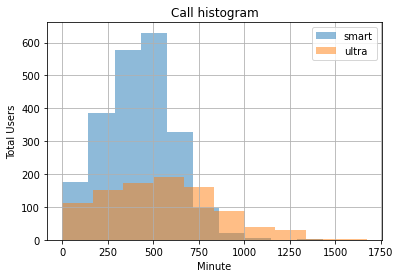

In [21]:
smart_t = df_all.query('tariff == "smart"')
ultra_t = df_all.query('tariff == "ultra"')
smart_t.call_time.hist(alpha = 0.5)
ultra_t.call_time.hist(alpha = 0.5)
plt.legend(['smart', 'ultra'])
plt.xlabel('Minute')
plt.ylabel('Total Users')
plt.title('Call histogram')


Text(0.5, 1.0, 'Message count histogram')

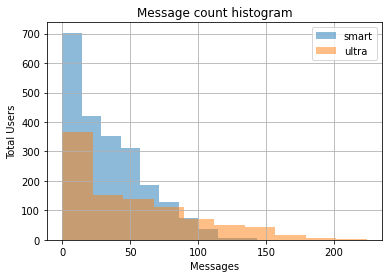

In [22]:
smart_t.message_count.hist(alpha = 0.5)
ultra_t.message_count.hist(alpha = 0.5)
plt.legend(['smart', 'ultra'])
plt.xlabel('Messages')
plt.ylabel('Total Users')
plt.title('Message count histogram')


Text(0.5, 1.0, 'Internet consumption histogram')

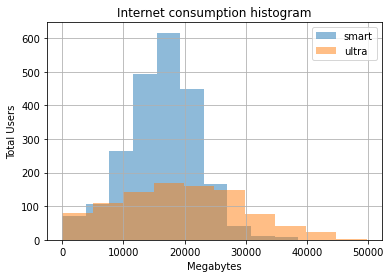

In [23]:
smart_t.mb_sum.hist(alpha = 0.5)
ultra_t.mb_sum.hist(alpha = 0.5)
plt.legend(['smart', 'ultra'])
plt.xlabel('Мegabytes')
plt.ylabel('Total Users')
plt.title('Internet consumption histogram')

### Conclusion: 
In terms of the duration of calls and Internet consumption, the number of messages, we see that:
   - The dispersion is greater on `Ultra`
   - on `Smart` users try to keep within the allotted limits.

### 5. Hypothesis research:

### 5.1 First hypothesis:

`Null hypothesis`:
   - The average revenue of ultra and smart tariffs is the same.
   
`Alternative hypothesis`:
   - The average revenue of ultra and smart tariffs is different.
   
Threshold value of alpha - 0.05

In [24]:
alpha = 0.05 
results = st.ttest_ind(
    smart_t['revenue'], 
    ultra_t['revenue'])

print(f'p-value: {results.pvalue}')

if (results.pvalue < alpha):
    print("Rejecting the null hypothesis")
else:
    print("Failed to reject the null hypothesis")

p-value: 2.1830308249112924e-155
Rejecting the null hypothesis


**The conclusion is that the average revenue of tariffs is really different. Null hypothesis is not confirmed**

### 5.2 Second hypothesis:

`Null hypothesis`:
   - the average revenue of users from Moscow is equal to the revenue of users from other regions.
   
`Alternative hypothesis`:
   - the average revenue of users from Moscow differs from the revenue of users from other regions.
   
Threshold value of alpha - 0.05

In [25]:
df_all_city = df_all.merge(users, on = 'user_id')
df_moskow = df_all_city.query('city == "Москва"')
df_any = df_all_city.query('city != "Москва"')

In [26]:
alpha = 0.05 
results = st.ttest_ind(
    df_moskow['revenue'], 
    df_any['revenue'])

print(f'p-value: {results.pvalue}')

if (results.pvalue < alpha):
    print("Rejecting the null hypothesis")
else:
    print("Failed to reject the null hypothesis")

p-value: 0.4619932225305272
Failed to reject the null hypothesis


#### Conclusion - the average revenue in Moscow and other cities is practically the same.

### General conclusions:
- Opened several tables, looked at the data, processed them for analysis.
- In the course of the work, pivot_tables and histograms were used.
- Made the following conclusions:
    - For the operator, the ultra tariff is more profitable, as it brings more revenue.
    - In the smart tariff, users limit themselves and try not to go beyond the limits, but basically they have to pay extra for minutes and gigabytes. Smart tariff is more favorable for users
    - We checked the hypotheses, the average revenue in Moscow does not differ from other cities, and the average revenue of tariffs differs